# Evaluation

Evaluation of SVM and RandomForest using ROC Curves and Confussion Matrix

Here we compare the results of using the NTU Dataset with skeleton data and with skeleton and video data. Furthermore, evaluate the features from our created dataset

In [9]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Display Helpers

Helpers to print graphically the ROC Curves and Confussion Matrix

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predecido')

    plt.show()


In [11]:
def print_roc(y_test, y_score, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    
    colors = itertools.cycle(['b', 'g', 'r', 'c', 'm'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Curva ROC de la clase {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ratio de Falso Positivo')
    plt.ylabel('Ratio de Verdadero Positivo')
    plt.title('Curvas ROC')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
movementsOwn = ['Recepcion', 'Levantada', 'Saque']

movementsNTU = ['Lanzar', 'Ponerse de pie', 'Patear', 'Saltar', 'Caer']

## Read Data

In [13]:
# NTU Skeleton features

CSV_DELIMITER = ','

rootFolder = '/home/a20122064/'
featuresFile = 'skeleton2.csv'
file = open(rootFolder + featuresFile, 'r', newline='')
reader = csv.reader(file, delimiter=CSV_DELIMITER)

data = np.array([row for row in reader])
file.close()

X = scale(data[:,0:-1].astype(np.float)) # ignore filename and class
# X = X[X[:,-1] > 0] # ignore invalid data about speed

y = data[:,-1].astype(np.int)

X.shape

(849, 21)

In [52]:
# NTU Skeleton + Video features

file = open('/home/a20122064/video+skeleton.csv', 'r', newline='')
reader = csv.reader(file, delimiter=CSV_DELIMITER)

data = np.array([row for row in reader])
file.close()

X_video = scale(data[:,0:-1].astype(np.float)) # ignore filename and class
# X = X[X[:,-1] > 0] # ignore invalid data about speed

y_video = data[:,-1].astype(np.int)

X_video.shape

(215, 7392)

In [35]:
# Own dataset Skeleton features

file = open('/home/a20122064/data/TesisData/features-real2.csv', 'r', newline='')
reader = csv.reader(file, delimiter=CSV_DELIMITER)

data = np.array([row for row in reader])
file.close()

X_own = scale(data[:,1:-1].astype(np.float)) # ignore filename and class
X_own = X_own[X_own[:,-1] > 0] # ignore invalid data about speed

y_own = data[:,-1].astype(np.int)

X_own.shape

(101, 16)

## Resample Data

We do this to make sure to keep the same proportion of elements in both train and test sets

In [57]:
def resampleData(X, y, test_size = 0.5):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    n_classes = len(le.classes_)
    
    samples = {}

    for c in range(n_classes):
        samples[c] = []

    for i, row in enumerate(X):
        samples[y[i]].append(row)

    X_train, X_test = [], []
    y_train, y_test = [], []

    for c in range(n_classes):
        matrix = np.matrix(samples[c])
        cutIndex = int(round(matrix.shape[0]*(1-test_size)))
        X_train += matrix[0:cutIndex].tolist()
        X_test += matrix[cutIndex:].tolist()
        y_train += [c] * cutIndex
        y_test += [c] * (matrix.shape[0] - cutIndex)

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


In [20]:
def dataInfo(X_train, X_test, y_train, y_test, movements):
    print('Train set: {}'.format(len(X_train)))

    for (index, mov) in enumerate(movements):
        print('  {}: {}'.format(mov, np.array(X_train)[np.array(y_train) == index].shape[0]))

    print('Test set: {}'.format(len(X_test)))

    for (index, mov) in enumerate(movements):
        print('  {}: {}'.format(mov, np.array(X_test)[np.array(y_test) == index].shape[0]))
    

In [58]:
X_train, X_test, y_train, y_test = resampleData(X, y, test_size=1/3)

dataInfo(X_train, X_test, y_train, y_test, movementsNTU)

Train set: 566
  Lanzar: 117
  Ponerse de pie: 116
  Patear: 111
  Saltar: 111
  Caer: 111
Test set: 283
  Lanzar: 58
  Ponerse de pie: 58
  Patear: 56
  Saltar: 55
  Caer: 56


In [59]:
X_train_video, X_test_video, y_train_video, y_test_video = resampleData(X_video, y_video, test_size=1/3)

dataInfo(X_train_video, X_test_video, y_train_video, y_test_video, movementsNTU)

Train set: 143
  Lanzar: 32
  Ponerse de pie: 31
  Patear: 27
  Saltar: 26
  Caer: 27
Test set: 72
  Lanzar: 16
  Ponerse de pie: 15
  Patear: 14
  Saltar: 13
  Caer: 14


In [60]:
X_train_own, X_test_own, y_train_own, y_test_own = resampleData(X_own, y_own, test_size=1/3)

dataInfo(X_train_own, X_test_own, y_train_own, y_test_own, movementsOwn)

Train set: 67
  Recepcion: 23
  Levantada: 26
  Saque: 18
Test set: 34
  Recepcion: 12
  Levantada: 13
  Saque: 9


## Tuning Hyperparameters

We perform a grid search for finding the best hyper parameters for the given dataset

In [25]:
def bestClf(model, X_train, y_train, parameters):

    clf = GridSearchCV(model, parameters)
    clf.fit(X_train, y_train)

    print(clf.best_params_)
    bestClf = clf.best_estimator_

    return bestClf, clf


In [26]:
%%time

bestSVM, svmGridClf = bestClf(SVC(), X, y, {'kernel': ['rbf', 'linear'], 'C': np.logspace(-2, 2, 9), 'gamma': np.logspace(-4, 4, 9)})
bestRF, rfGridClf = bestClf(RandomForestClassifier(), X, y, {'n_estimators': [20, 30, 40], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40], 'max_features': ['sqrt', 'log2']})
# bestXG = bestClf(GradientBoostingClassifier(), X_train, X_test, y_train, y_test, {'learning_rate': np.logspace(-2, 2, 9), 'n_estimators': [100, 200, 500], 'criterion': ['friedman_mse', 'mse', 'mae']})

{'gamma': 0.01, 'kernel': 'rbf', 'C': 10.0}
{'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'n_estimators': 30}
CPU times: user 1min 18s, sys: 65.5 ms, total: 1min 18s
Wall time: 1min 18s


In [25]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
pd.DataFrame(data=svmGridClf.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_train_score', 'param_C', 'param_gamma', 'param_kernel', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score']].to_csv('svm_grid.csv')
pd.DataFrame(data=rfGridClf.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_train_score', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score']].to_csv('rf_grid.csv')
#     display(pd.DataFrame(data=gridClf.cv_results_)[['mean_train_score', 'param_C', 'param_gamma', 'param_kernel']])

# pd.DataFrame(data=gridClf.cv_results_)

## Testing

As we are testing two classifiers, it was to write a common function to test several classifiers

In [38]:
def testClassifier(model, X_train, X_test, y_train, y_test, name, prob_method, movements):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)

    y_score = getattr(model, prob_method)(X_test)
    n_classes = y_score.shape[1]
    y_test_binarized =  label_binarize(y_test, range(n_classes))
    
    print_roc(y_test_binarized, y_score, movements)
    plot_confusion_matrix(confusion_matrix(y_test, y_predicted), movements, title=name + ' Norm', normalize=True)

1. ### NTU Skeleton

SVM


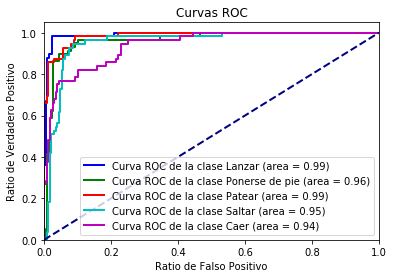

Matriz de confusión normalizada


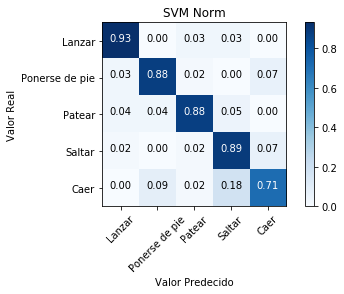

Random Forest


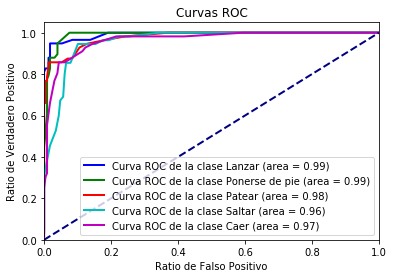

Matriz de confusión normalizada


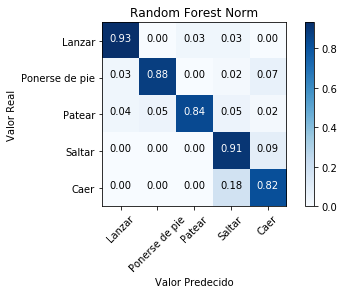

In [62]:
print('SVM')
testClassifier(bestSVM, X_train, X_test, y_train, y_test, 'SVM', 'decision_function', movementsNTU)
print('Random Forest')
testClassifier(bestRF, X_train, X_test, y_train, y_test, 'Random Forest', 'predict_proba', movementsNTU)

2. ### NTU Skeleton + Video vs Skeleton

Using Video features


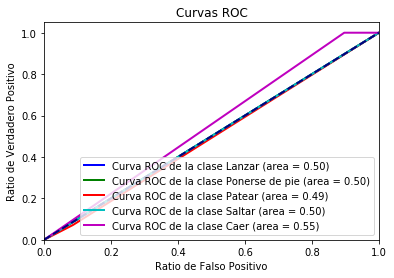

Matriz de confusión normalizada


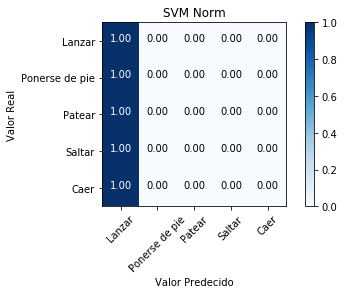

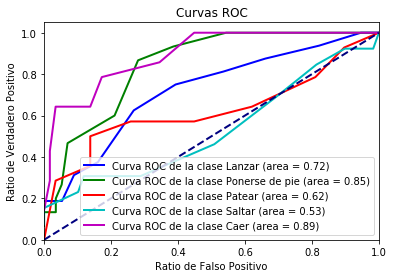

Matriz de confusión normalizada


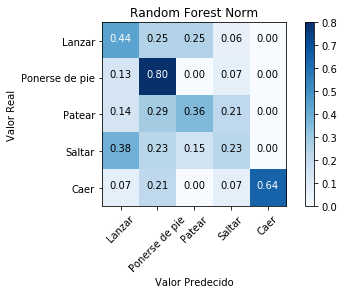

Not using Video features


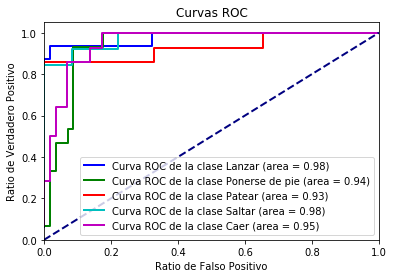

Matriz de confusión normalizada


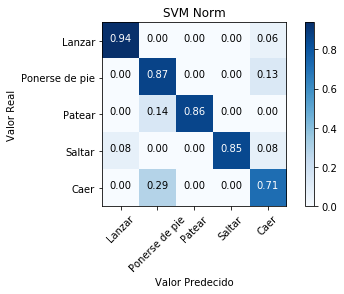

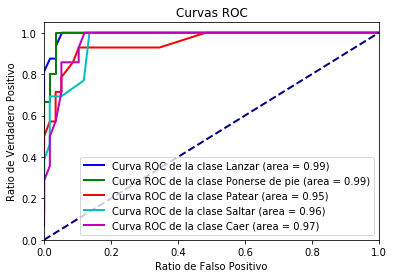

Matriz de confusión normalizada


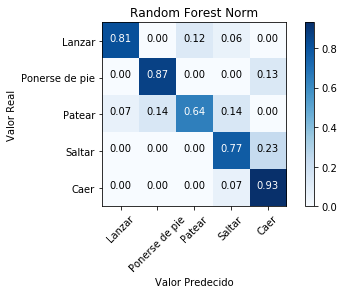

In [66]:
print('Using Video features')
testClassifier(bestSVM, X_train_video, X_test_video, y_train_video, y_test_video, 'SVM', 'decision_function', movementsNTU)
testClassifier(bestRF, X_train_video, X_test_video, y_train_video, y_test_video, 'Random Forest', 'predict_proba', movementsNTU)
print('Not using Video features')
testClassifier(bestSVM, X_train_video[:, 0:21], X_test_video[:, 0:21], y_train_video, y_test_video, 'SVM', 'decision_function', movementsNTU)
testClassifier(bestRF, X_train_video[:, 0:21], X_test_video[:, 0:21], y_train_video, y_test_video, 'Random Forest', 'predict_proba', movementsNTU)

2. ### Own Dataset Skeleton

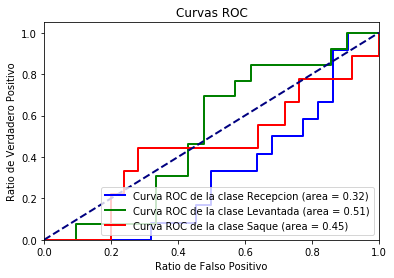

Matriz de confusión normalizada


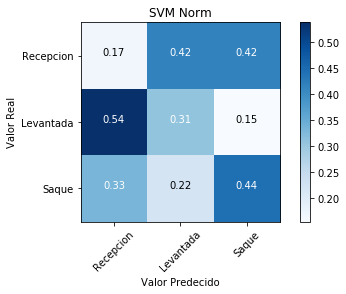

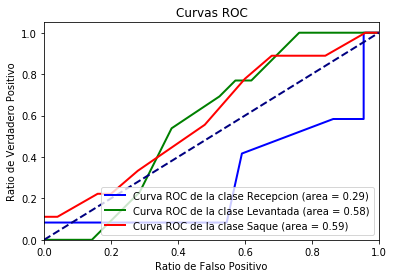

Matriz de confusión normalizada


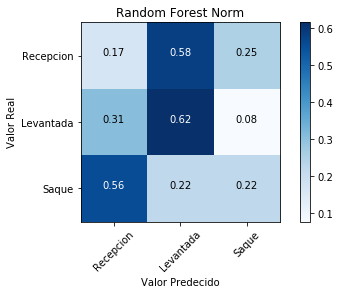

In [68]:
testClassifier(bestSVM, X_train_own, X_test_own, y_train_own, y_test_own, 'SVM', 'decision_function', movementsOwn)
testClassifier(bestRF, X_train_own, X_test_own, y_train_own, y_test_own, 'Random Forest', 'predict_proba', movementsOwn)